<h2>1.0 Importação de bibliotecas e criação de funções auxiliares<h2>

In [47]:
import numpy as np
import cv2
from matplotlib import pyplot as py

<h4>Matriz de Quantização<h4>
    Para este algoritmo sera usado uma matriz de quantização 8x8 padrão da compressão JPEG assim evitando a necessidade de enviar esta matriz no cabeçalho do arquivo comprimido. Com isso o tamanho do arquivo comprimido será menor.

In [48]:
QuantizationMatrix = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])


<h4>Função para realizar a DCT<h4>
    Esta função recebe uma matriz no domínio de imagem e usando a transformada discreta dos cossenos(DCT) ela converte a matriz para o domínio de frêquencia. A DCT foi escolhida para realizar está transformação ao invés de fourier devido a está última gerar uma resposta em números complexos.

In [49]:
def doDCT_2D(img):
    return cv2.dct(img)

<h4>Função para realizar a IDCT<h4>
    Esta função recebe uma matriz no domínio das frêquencias e através da inversa da transformada dos cossenos(IDCT).

In [50]:
def doIDCT_2D(img):
    return cv2.idct(img)

<h4>Função de Quantização<h4>
    A função de Quanticação recebe uma matriz no dominío das frêquencias de tamanho 8x8 e divide pela matriz de Quantização. Através deste processo varios dos coeficientes da matriz se tornam zero, o que acaba tornando a matriz em uma matriz esparça o que ajuda no processo de compressão da imagem devido ao menor número de valores guardados.

In [51]:
def quatization(dct,QuantizationMatrix):
    temp = np.divide(dct,QuantizationMatrix)
    return temp

<h4>Função de Dequantização<h4>
    Esta função multiplica uma matriz 8x8 do domínio de frêquencia com a matriz de quanticação. Isso é realizado no processo de descompreesão para retornar os valores originais da matriz antes da quantização.

In [52]:
def dequantization(idct,QuantizationMatrix):
    temp = np.multiply(idct,QuantizationMatrix)
    return temp

<h4>Função de Media<h4>
    Recebe uma matriz 3x3 de entrada e retira a mediana desta. Esta função é utilizada no filtro das medianas para alterar o valor central da matriz.

In [53]:
def median(matrix):
    vector = np.reshape(matrix,-1)
    vector.sort()
    med = vector[5]
    return med

<h4>Funcoes de qualidade da compressão<h4>
    O RMSE(erro médio quadratico) é o somatario do erro entre o pixel(x,y) da imagem original e o pixel(x,y) da imagem alterada ao quadrado divido pelo tamanho da matriz. Essa metrica mede o quanto em media o valor dos pixels da sua imagem desviam do valor original e devido ao fato de considerar o erro quadrático então os pixels com diferenças mais discrepantes acabam fazendo mais peso no resultado da métrica.<br>
    Já o PSNR(relaçao sinal ruido de pico) é a relação entre a energia maxima do sistema, neste caso 255, pelo ruido do sistema, neste caso o erro é medido através do RMSE.

In [75]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

<h2>1.1 Algoritmo de Compresão<h2>

<h4>Filtro da Mediana<h4>
    O primeiro passo do algoritmo de compreensão realizado é passar a imagem por um filtro de medianas com uma mascára de tamanho 9x9 e que ignora as bordas da imagem, com isso temos uma diminuição do ruido e aumento de redundância, o que nos dá a primeira diminuição de informação para comprimir o arquivo.

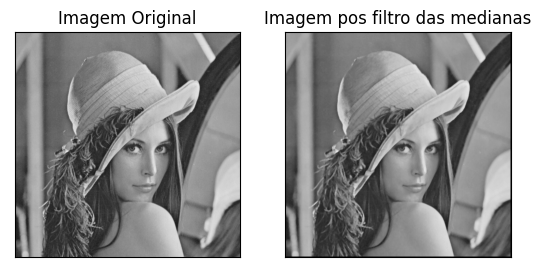

In [76]:
OriginalImage = cv2.imread('lena512.pgm',0)
OriginalImage = OriginalImage.astype(float)
Axis = OriginalImage.shape
filterImage = np.zeros(Axis,dtype = np.float64)

for i in range(1,Axis[0] - 1):
    for j in range(1,Axis[1] - 1):
        filterred = median(OriginalImage[i-1:i+2,j-1:j+2])
        filterImage[i,j] =  filterred
py.subplot(121),py.imshow(OriginalImage, cmap = 'gray', clim=(0, 255))
py.title('Imagem Original'), py.xticks([]), py.yticks([])
py.subplot(122),py.imshow(filterImage, cmap = 'gray', clim=(0, 255))
py.title('Imagem pos filtro das medianas'), py.xticks([]), py.yticks([])
py.show()

<h4>Processo de aplicação da DCT<h4>
    Agora a matriz filtrada é subtraida por 128 para normaliza-la. Em seguida a matriz é passada por uma DCT para converter do dominio da imagem para o dominio de frêquencia e é quantizada. Por motivos de custo computacional a aplicação da DCT e da quantização não são feitas diretamente na matriz, mas sim em submatrizes de 8x8.<br>
    Importante ressaltar que o primeiro elemento da dct, também chamada de componente DC não é quantizada, pois nele é carregada o valor de media dos pixels daquela região, então qualquer erro neste valor pode causar um aumento grande no RMSE.

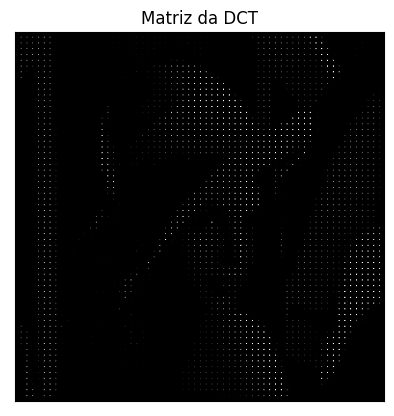

In [77]:
filterImage = filterImage - 128
step = 8
DCTMatrix = np.zeros(Axis,dtype = np.float64)

for i in range(0,Axis[0],step):
    for j in range(0,Axis[1],step):
        dct = doDCT_2D(filterImage[i:i+step,j:j+step])
        DCComponent = dct[0,0]
        dctQuant = quatization(dct,QuantizationMatrix)
        dctQuant[0,0] = DCComponent
        DCTMatrix[i:i+step,j:j+step] = dctQuant
DCTMatrix = np.round(DCTMatrix)
py.imshow(DCTMatrix, cmap = 'gray', clim=(0, 255))
py.title('Matriz da DCT'), py.xticks([]), py.yticks([])
py.show()

<h4>Processo de contar valores nao zeros<h4>
    Com a matriz da DCT completa e quantizada conta-se os valores desta não zero da matriz, já que esta informação será importante para o resto do algoritmo.

In [78]:
notZero = 0
for i in range(Axis[0]):
    for j in range(Axis[1]):
        if DCTMatrix[i,j] != 0:
            notZero = notZero + 1
Components = np.zeros(notZero,dtype = np.int16)
offset = np.zeros(notZero,dtype=np.int16)
print("Numero de elementos nao nulos: ",notZero)

Numero de elementos não nulos:  26095


<h4>Processo de salvar valores não zero<h4>
    Agora com o número de não zeros e sabendo que este valor é bem menor que os número de posições da matriz devido a caracteristica esparça desta matriz, nós salvamos em dois vetores as componentes não zero da matriz e o seu offset. Este offset é a distância entre dois elementos não zeros na matriz.

In [79]:
s = 0
off = 0
for i in range(0,Axis[0]):
    for j in range(0,Axis[1]):
        if DCTMatrix[i,j] != 0:
            Components[s] = DCTMatrix[i,j]
            offset[s] = off
            s = s+1
            off = 0
        else:
            off = off + 1
print("Vetor de elementos: ",Components)
print("Vetor de offset's: ",offset)

Vetor de elementos:  [-38 -18 -18 ...   1   1   1]
Vetor de offset's:  [ 0  0  0 ...  7 31 15]


<h4>Processo de escrever o arquivo<h4>
    O arquivo de compressão criado possui um cabeçalho pequeno ele salva apenas o tamanho dos eixos  e y em duas escritas de 16 bits em seguida o número de elementos não zeros é escrito em 32 bits. Depois do cabeçalho é escrito os valores não zeros da matriz de forma que os primeiros 16 bits são sempre a componente não zero da matriz e os proximos 16 bits são o offset desta componente em relação a componente anterior.
    <br>
    Importante relatar que caso a codificação de huffman fosse usada o numero de bits usados na escrita do arquivo seria menor.

In [80]:
img = open("lena.cizio","wb")
img.write(np.int16(Axis[0]))
img.write(np.int16(Axis[1]))
img.write(np.int32(notZero))
for l in range(notZero):
    img.write(Components[l])
    img.write(offset[l])
img.close()

<h2>1.2 Algoritmo de descompressão<h2>

<h4>Processo de abertura do arquivo<h4>
    Aqui se inicia o processo de descompressão da imagem, o primeiro do algoritmo é ler os 8 primeiros bytes do arquivo que são o cabeçalho da imagem, com isso podemos saber o tamanho da imagem e o número de elementos não zero. Em seguida com o número de elementos não zeros conhecidos podemos remontar os vetor de componentes e offsset's.

In [81]:
imgRead = open("lena.cizio","rb")
header = imgRead.read(8)
headerX = int.from_bytes(header[0:2],'little')
headerY = int.from_bytes(header[2:4],'little')
headerNotZeros = int.from_bytes(header[4:8],'little')
Res = np.zeros((headerX,headerY),dtype=np.int16)
value = np.zeros(headerNotZeros,dtype=np.int16)
offsetRead = np.zeros(headerNotZeros,dtype=np.int16)
for l in range(headerNotZeros):
    packet = imgRead.read(4)
    value[l] = int.from_bytes(packet[0:2],'little')
    offsetRead[l] = int.from_bytes(packet[2:4],'little')

print("numero de elementos nao zero: ",headerNotZeros)
print("tamanho da imagem: ",headerX,"x",headerY)
print("vetor de elemtos: ",value)
print("vetor de offset's: ",offset)

numero de elementos não zero:  26095
tamanho da imagem:  512 x 512
vetor de elemtos:  [-38 -18 -18 ...   1   1   1]
vetor de offset's:  [ 0  0  0 ...  7 31 15]


<h4>Processo de reconstrução da matriz<h4>
    Agora com todos os dados do arquivo de compressão obtidos podemos realizar a reconstrução da matriz

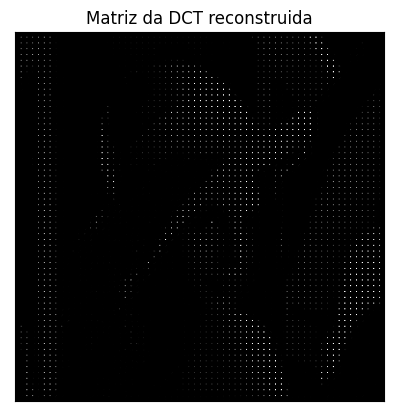

In [82]:
count = 0
k = 0
for i in range(headerX):
    for j in range(headerY):
        if k < headerNotZeros:
            if offset[k] != count:
                count = count + 1
            else:
                Res[i,j] = value[k]
                count = 0
                k = k + 1
py.title("Matriz DCT reconstruida")
py.imshow(Res, cmap = 'gray', clim=(0, 255))
py.title('Matriz da DCT reconstruida'), py.xticks([]), py.yticks([])
py.show()

<h4>Processo de reconstrução de imagem<h4>
    Finalmento com a matriz reconstruida, utilizando a matriz de quantização pode-se desquantizar a matriz da dct, novamente preservando as componentes DC e usar a inversa da transformada discreta dos cossenos para retornar a matriz para o domínio da imagem. Todo este processo é feito em matrizes menores de 8x8 para reduzir o custo computacional e também manter o padrão adotado no processo de compressão. 
    <br>
    Finalizando o algoritmo, soma-se 128 devido a normalização do processo de compressão e então obtemos uma versão aproximada da imagem original.

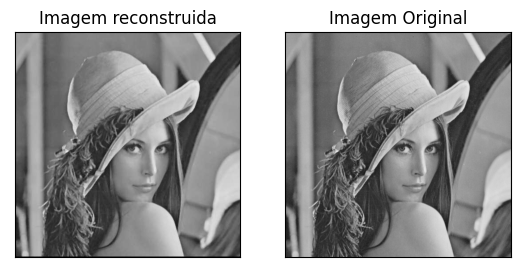

In [85]:
size = Res.shape
IDCTMatrix = np.zeros(size,dtype=np.float64)
for i in range(0,size[0],step):
    for j in range(0,size[1],step):
        idctQuant = Res[i:i+step,j:j+step]
        DCComponent = idctQuant[0,0]
        idctDequant = dequantization(idctQuant,QuantizationMatrix)
        idctDequant[0,0] = DCComponent
        idct = doIDCT_2D(np.float64(idctDequant))
        IDCTMatrix[i:i+step,j:j+step] = idct
IDCTMatrix = IDCTMatrix + 128
py.subplot(121),py.imshow(IDCTMatrix, cmap = 'gray', clim=(0, 255))
py.title('Imagem reconstruida'), py.xticks([]), py.yticks([])
py.subplot(122),py.imshow(OriginalImage, cmap = 'gray', clim=(0, 255))
py.title('Imagem Original'), py.xticks([]), py.yticks([])
py.show()

<h4>Metricas de qualidade<h4>
    No exemplo do algoritmo foi-se usado como base a imagem 512x512 da lena, e neste processo obteve-se um RMSE de 12.744 o que é um erro medio dentro das margens do aceitavel e um PSNR de 26.025 que também está dentro da faixa para se ter uma boa qualidade. Ou seja o algoritmo de compressão e descompressão desenvolvido conseguiu manter a imagem com uma boa qualidade.

In [86]:
print ("RMSE: %5.3f" % rmse(OriginalImage,IDCTMatrix))
print ("PSNR: %5.3f" % psnr(OriginalImage,IDCTMatrix))

RMSE: 12.744
PSNR: 26.025


<h4>Taxa de Compressão<h4>
    A taxa de compressão da imagem da lena foi de 2.5. Em outras imagens tentadas a taxa variou entre 2 e 2.5, com isso pode-se observar que o objetivo do trabalho foi alcançado e as metricas de qualidade e compressão conseguiram ser equilibradas, conseguindo aliar a manutenção da qualidade da imagem com uma taxa de compressão satisfatoria.
    <br>
    Importante ressaltar que caso a codificação de Huffman fose utilizada no pipeline do algoritmo, provavelmente a taxa de compressão seria maior.

In [87]:
import os
originalFile = 'lena512.pgm'
compressedFile = 'lena.cizio'
statsOriginal = os.stat(originalFile)
statsCompressed = os.stat(compressedFile)
print("Taxa de Compressao: ",np.int64(statsOriginal.st_size)/np.int64(statsCompressed.st_size))

Taxa de Compressao:  2.511572211365291
